# Automate the detection of brain tumors. 

## Application

Een image of list van images die eerst door de classificatie part gaat. Indien de brain image een tumor bevat zal het ook door de segmentatie gaan. Dit applicatie is gemaakt als hulpmiddel voor de dokter en niet als vervanger. 

A list of images that first go trought the classification part. If the model predictics that the image contains a tumor, then it will been forwarded to the segmentation model.

### Example of the application

<img src="./diagram/brain.png">
<img src="./diagram/TumorDetected.png">


In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.utils import shuffle

import cv2


import matplotlib.image as mpimg
from skimage.io import imread, imshow
from skimage.color import rgb2gray
from skimage import data, color, io, filters, morphology,transform, exposure, feature, util
from scipy import ndimage

from sklearn.preprocessing import StandardScaler
import seaborn as sns




import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, BatchNormalization,concatenate
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras import backend as K
from tensorflow.python.keras.layers.core import Dropout, Lambda
from tensorflow.python.keras.layers.core import * 
from tensorflow.keras.layers import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.text import Tokenizer

import glob


from tensorflow.keras.callbacks import *
# Voor GPU support
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

pd.set_option('display.max_rows',10000)
pd.set_option('display.max_columns',10000)

### list images toekennen 


In [2]:
path_images = './dataset/test/'

# Separate images and masks in the directory
images_dir = glob.glob(path_images + "*.tif")

In [3]:
image_dir = []
for images in images_dir:
    #image = imread(images)
    image = images
    image_dir.append(image)

images = image_dir

### Uitvoering

In [4]:
# Dice coefficient loss
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2.*intersection + smooth)/(K.sum(K.square(y_true),-1)+ K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

# model inlezen 
#read model
#load model
VGG19 = keras.models.load_model('./Model/VGG19.h5')
OwnClassificationNN = keras.models.load_model('./Model/OwnClassificationNN_aug.h5')
OwnClassificationNNAUG = keras.models.load_model('./Model/OwnClassificationNN_aug.h5')
segmentationmodel = keras.models.load_model('./Model/UNet.h5', custom_objects={"dice_coef": dice_coef,"dice_coef_loss": dice_coef_loss })

if len(images) > 1:
    #resize to 128
    image_size = 128
    images_resized = []
    i = 0
    #reading images & resize 
    for image in images:
        
        #inlezen
        image = imread(images[i])
       
        #resize
        resized = transform.resize(image,(image_size,image_size),mode='constant',anti_aliasing=True)
        images_resized.append(resized)
        
        i += 1
        if i > len(images):
            break
        
    images = images_resized
    images = np.asarray(images)
    print(images.shape)
    
    # classificatie 
    # (if tumor ->> naar segmantatie model doorsturen) 
    # (if not ->> show images en vermeld dat er geen tumor is gevonden.
    class1 = []
    class0 = []
    predictions = []
    i = 0
    for eachImage in images:
        # # reshape naar 1,image_size,image_size,3
        eachImage = np.asarray(eachImage)
        eachImage = eachImage.reshape(1,image_size, image_size,3)
    
        #prediction class
        #predictions
        models = [VGG19, OwnClassificationNN, OwnClassificationNNAUG]
        preds = [model.predict(eachImage) for model in models]
        preds= np.array(preds)
        weights = [0.35, 0.3, 0.35] #best weights

        #use tensordot
        weighted_pred = np.tensordot(preds, weights, axes=((0),(0)))
        predictionClassification= np.argmax(weighted_pred, axis=1)

        
        #predictionClassification = OwnClassificationNN.predict(eachImage)
        #predictionClassification = np.argmax(predictionClassification)
        
        print(predictionClassification)
        if predictionClassification == 1:
            
            
            # Segmentation
            predictionSegmentation = segmentationmodel.predict(eachImage)
            #print("Segmentation: ",segmentationmodel)

            # reshape naar 1,image_size,image_size,3
            predictionSegmentation = predictionSegmentation.reshape(image_size, image_size,3)
            
            class1.append(predictionSegmentation)
            predictions.append(predictionSegmentation)  
        else:
            # reshape naar image_size,image_size,3
            eachImage = eachImage.reshape(image_size, image_size,3)
            
            #append image without tumor
            class0.append(eachImage)
            
            predictions.append(eachImage)
            
        i += 1
        if i > len(images):
            break



(4, 128, 128, 3)
[0]
[0]
[1]
[1]


### List - No tumor detected

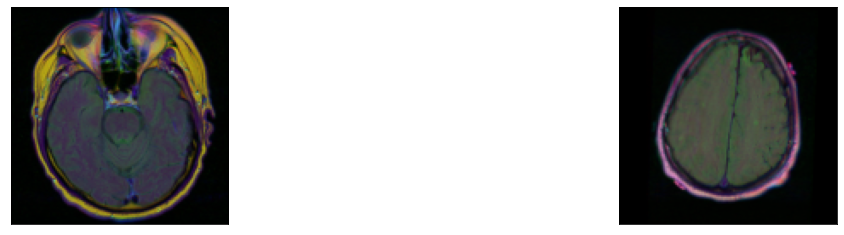

In [5]:
n = len(class0) # number of images to plot
plt.figure(figsize=(20, 4))
for i in range(n):
    # Originals mask
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(class0[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### List - tumor detected

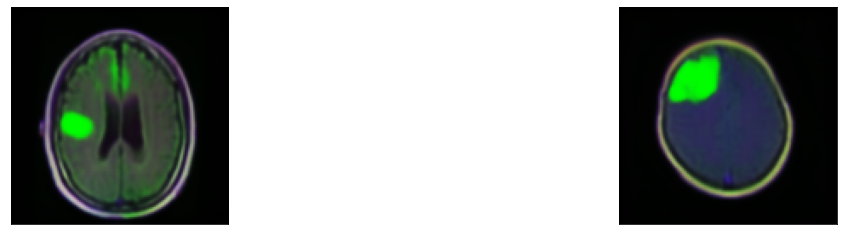

In [6]:
n = len(class1) # number of images to plot
plt.figure(figsize=(20, 4))
for i in range(n):
    # Reconstructions
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(class1[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()